In [3]:
# we are using coco dataset containing 10,000 images
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab,lab2rgb
import torch
from torch import nn,optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader


In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu"
)
use_colab = None
device


device(type='cuda')

In [5]:
# download fastai to download part of the coco dataset
!pip install fastai==2.7.13

In [6]:
from fastai.data.external import untar_data,URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [7]:

# Check if using Colab or local environment
use_colab = True  # Set this to True if using Colab
cocopath = coco_path
local_path = "your_path_to_local_dataset"

# Set the dataset path based on the environment
path = cocopath if use_colab else local_path

# Get a list of all image file paths in the dataset
paths = glob.glob(path + "/*.jpg")

# Set a random seed for reproducibility
np.random.seed(42)

# Choose a random subset of 15,000 images without replacement
subset_size = 15_000
subset_paths = np.random.choice(paths, subset_size, replace=False)

# Create random permutations of indices for training and validation split
rand_idxs = np.random.permutation(subset_size)
train_idxs, val_idxs = rand_idxs[:10_000], rand_idxs[10_000:]

# Select training and validation paths based on the indices
train_paths, val_paths = subset_paths[train_idxs], subset_paths[val_idxs]

# Print the number of training and validation paths
print(f"Number of training paths: {len(train_paths)}")
print(f"Number of validation paths: {len(val_paths)}")




Number of training paths: 10000
Number of validation paths: 5000


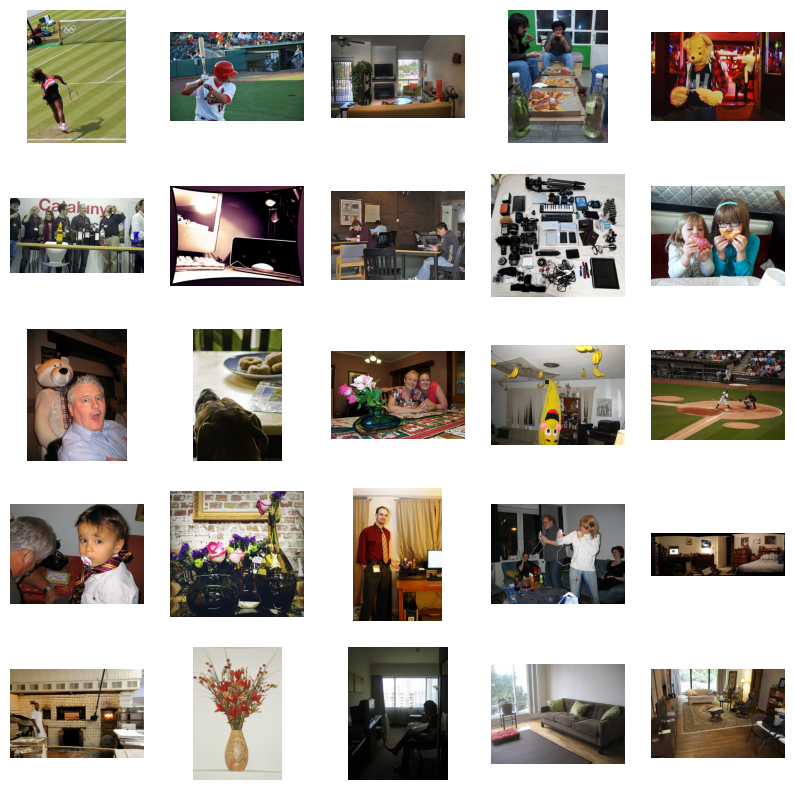

In [8]:

import matplotlib.pyplot as plt
from PIL import Image

# Assuming you have already defined train_paths
_, axes = plt.subplots(5, 5, figsize=(10, 10))

for ax, img_path in zip(axes.flatten(), train_paths):
    # Display the image using matplotlib
    ax.imshow(Image.open(img_path))

    # Turn off axis labels
    ax.axis("off")

# Show the plot
plt.show()


In [9]:


SIZE = 512

class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE), Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE), Image.BICUBIC)
        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1.
        ab = img_lab[[1, 2], ...] / 110.

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(paths, split='train', batch_size=32, n_workers=os.cpu_count(), pin_memory=True):
    dataset = ColorizationDataset(paths, split=split)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader


In [10]:

train_dl = make_dataloaders(paths=train_paths, split="train")
val_dl = make_dataloaders(paths=val_paths, split="val")

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']

print(f"Number of batches in training dataloader: {len(train_dl)}")
print(f"Number of batches in validation dataloader: {len(val_dl)}")
print(f"Shape of Ls tensor: {Ls.shape}, Shape of abs_ tensor: {abs_.shape}")


Number of batches in training dataloader: 313
Number of batches in validation dataloader: 157
Shape of Ls tensor: torch.Size([32, 1, 512, 512]), Shape of abs_ tensor: torch.Size([32, 2, 512, 512])


In [11]:


class UNetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super(UNetBlock, self).__init__()
        self.outermost = outermost
        if input_c is None:
            input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout:
                up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class UNet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super(UNet, self).__init__()
        unet_block = UNetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UNetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UNetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UNetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)


In [12]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]

        # Use a loop to create layers for down-sampling
        for i in range(n_down):
            stride = 1 if i == (n_down - 1) else 2
            model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=stride)]

        # Add the final layer without normalization or activation
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]

        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        # Helper function to create a sequence of layers
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm:
            layers += [nn.BatchNorm2d(nf)]
        if act:
            layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [13]:
PatchDiscriminator(5)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(5, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [14]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 512, 512) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 62, 62])

In [15]:

class GANLoss(torch.nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))

        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        else:
            raise ValueError("Invalid gan_mode. Supported modes are 'vanilla' and 'lsgan'.")

    def get_labels(self, preds, target_is_real):
        labels = self.real_label if target_is_real else self.fake_label
        return labels.expand_as(preds)

    def forward(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss


In [17]:

def init_weights(net, init='norm', gain=0.05):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"Model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model


In [18]:
class MainModel(torch.nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super(MainModel, self).__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(UNet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)

        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()

        # Discriminator optimization
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        # Generator optimization
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()


In [19]:

class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count = 0
        self.avg = 0.
        self.sum = 0.

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {
        'loss_D_fake': loss_D_fake,
        'loss_D_real': loss_D_real,
        'loss_D': loss_D,
        'loss_G_GAN': loss_G_GAN,
        'loss_G_L1': loss_G_L1,
        'loss_G': loss_G
    }

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = [lab2rgb(img) for img in Lab]
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()

    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    fig, axes = plt.subplots(3, 5, figsize=(15, 8))

    for i, ax in enumerate(axes[0]):
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")

    for i, ax in enumerate(axes[1]):
        ax.imshow(fake_imgs[i])
        ax.axis("off")

    for i, ax in enumerate(axes[2]):
        ax.imshow(real_imgs[i])
        ax.axis("off")

    plt.show()

    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")


Model initialized with norm initialization
Model initialized with norm initialization


  0%|          | 0/313 [00:00<?, ?it/s]


Epoch 1/1
Iteration 100/313
loss_D_fake: 0.62789
loss_D_real: 0.60690
loss_D: 0.61739
loss_G_GAN: 1.38586
loss_G_L1: 12.04650
loss_G: 13.43235


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 44 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 70 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/

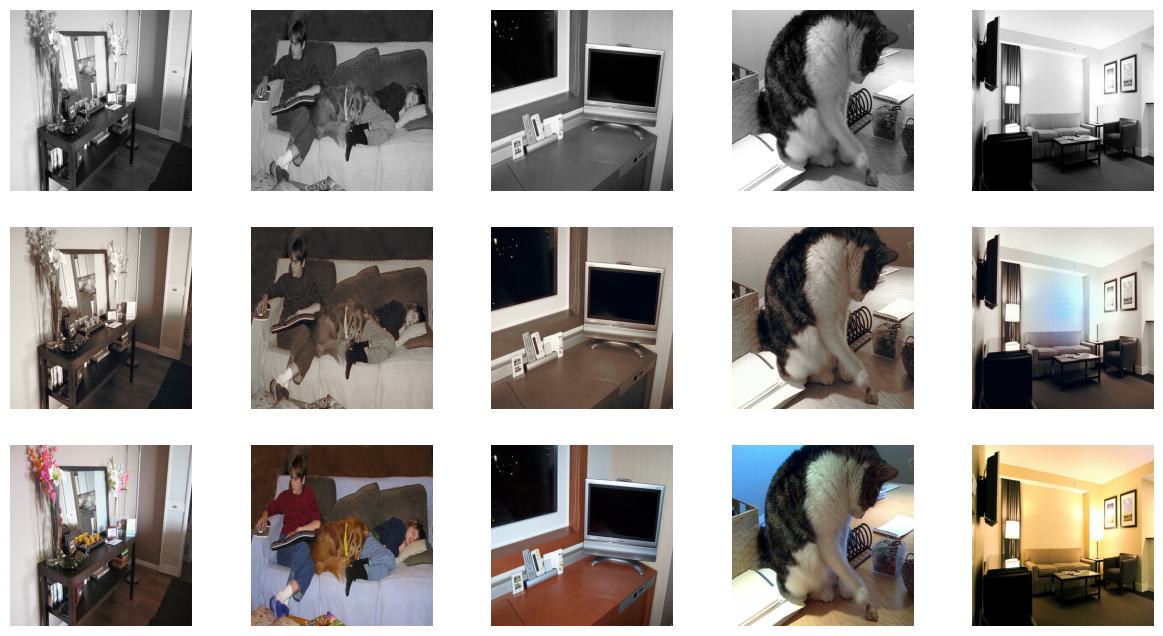


Epoch 1/1
Iteration 200/313
loss_D_fake: 0.44923
loss_D_real: 0.44989
loss_D: 0.44956
loss_G_GAN: 1.76801
loss_G_L1: 10.89520
loss_G: 12.66321


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 48 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 65 pixels
  return func(*args, **kwargs)


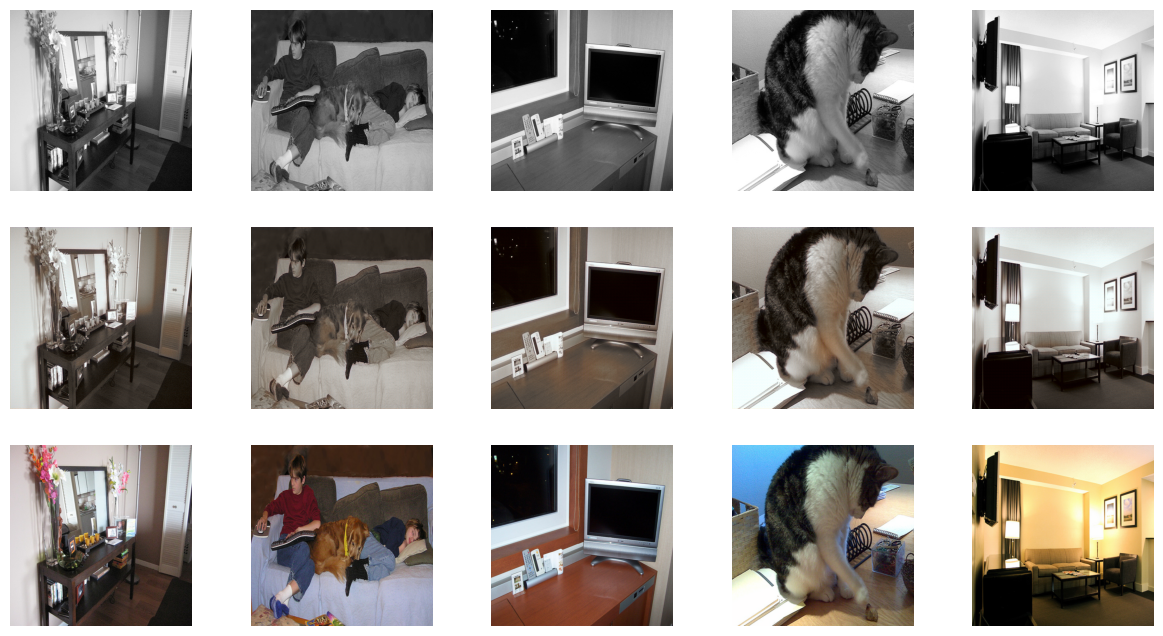


Epoch 1/1
Iteration 300/313
loss_D_fake: 0.44657
loss_D_real: 0.46007
loss_D: 0.45332
loss_G_GAN: 1.78265
loss_G_L1: 10.71169
loss_G: 12.49434


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 729 pixels
  return func(*args, **kwargs)


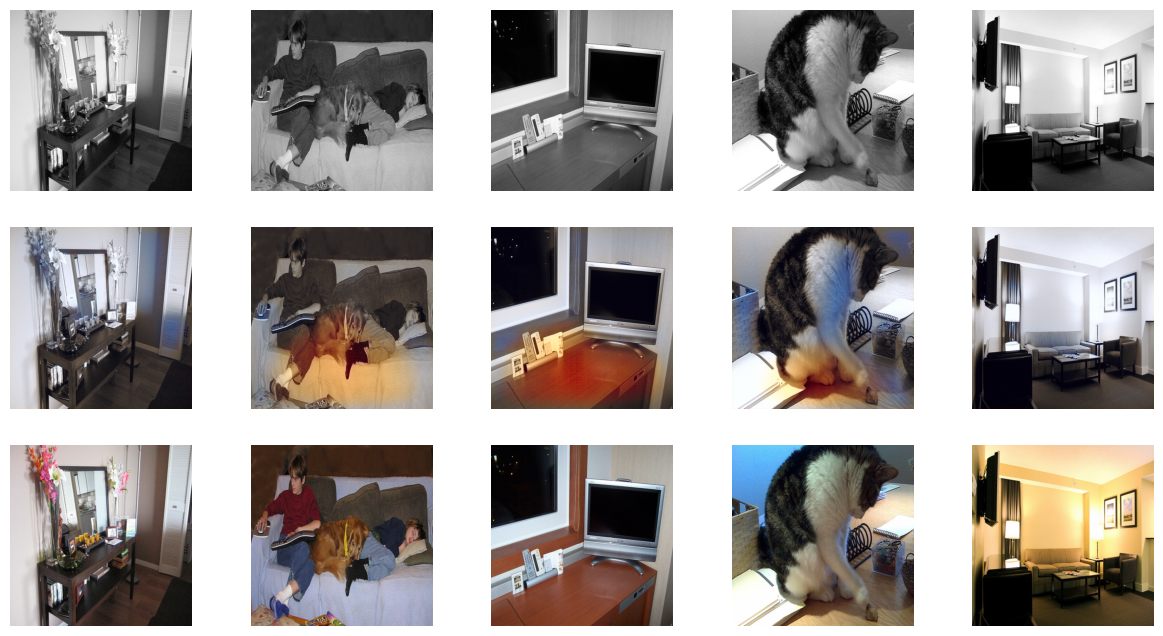


Epoch 1/1
Iteration 313/313
loss_D_fake: 0.45263
loss_D_real: 0.47001
loss_D: 0.46132
loss_G_GAN: 1.76154
loss_G_L1: 10.71339
loss_G: 12.47493


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 25 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 71 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 453 pixels
  return func(*args, **kwargs)


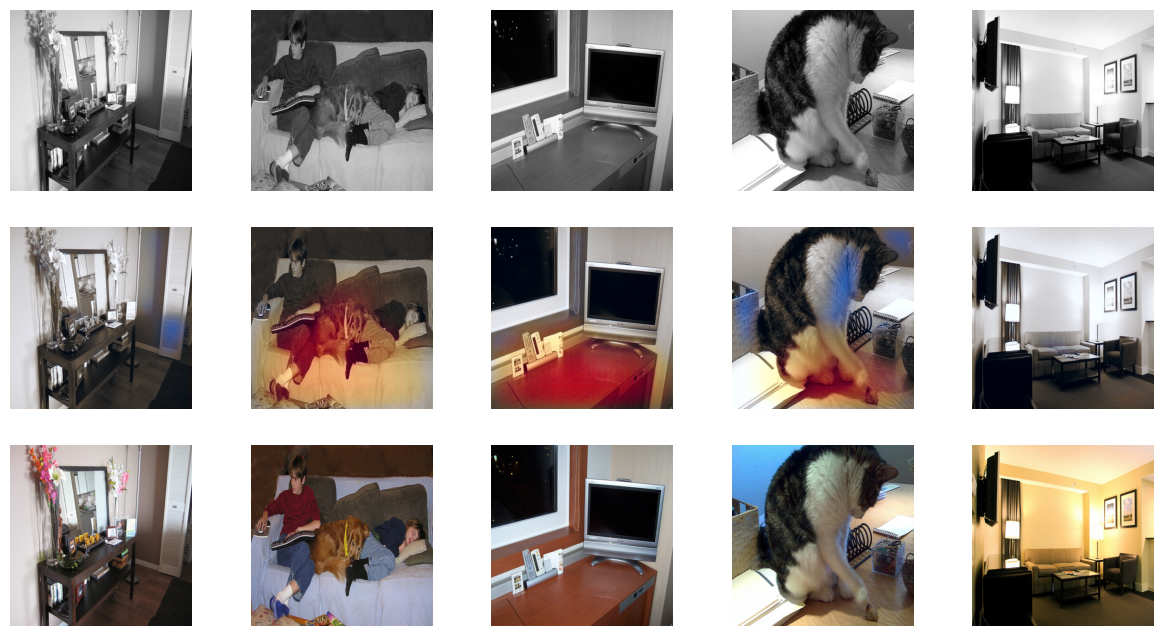

In [21]:

def train_model(model, train_dl, val_dl, epochs, display_every=100):
    fixed_data = next(iter(val_dl))  # Getting a fixed batch for visualizing the model output after fixed intervals

    for e in range(epochs):
        loss_meter_dict = create_loss_meters()  # Function returning a dictionary of objects to log the losses of the complete network
        for i, data in enumerate(tqdm(train_dl)):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0))  # Function updating the log objects

            if (i + 1) % display_every == 0 or i == len(train_dl) - 1:
                print(f"\nEpoch {e + 1}/{epochs}")
                print(f"Iteration {i + 1}/{len(train_dl)}")
                log_results(loss_meter_dict)  # Function to print out the losses
                visualize(model, fixed_data, save=False)  # Function displaying the model's outputs

model = MainModel()
train_model(model, train_dl, val_dl, epochs=1)


In [23]:
torch.save(model.state_dict(),'image_colorization.pth')